## クラスタリング結果を解釈する

In [681]:
import pandas as pd

In [682]:
df = pd.read_csv("../kadai_text_with_rating_and_clusters_kyokun.csv")
df.head(3)

,project_id,para_id,text,source,total_eval,eval_year,分野,region_detail,project_para_count,cluster,bad_flag,doc_weight,pc1,pc2,pc3
0,2010_0200600_4_f.txt,0,事前評価時に設定された運用効果指標の大半は実施機関でデータ収集がなされていない。実施機関が事...,2010_0200600_4_f.pdf,4.0,2010,運輸交通一般,東アフリカ,1,29,0.0,1.0,-0.166711,0.101845,0.070069
1,2010_0202100_4_f.txt,0,＜指標設定及び基準値の確認にかかる教訓＞本事業の事業事前評価表においては、運用指標と定性的指...,2010_0202100_4_f.pdf,3.0,2010,上水道,東南アジア,1,29,0.0,1.0,-0.131790,-0.030217,-0.071768
2,2010_0211100_4_f.txt,0,本事業では植林の活着率95％以上という非常に高い成果を達成した。侵食を受けやすい黄土が厚く堆...,2010_0211100_4_f.pdf,4.0,2010,環境問題,東アジア,2,6,0.0,0.5,0.127990,-0.062658,-0.053354


In [ ]:
import pandas as pd

# =========================================
# 0. year → period（例：5年ごとにまとめる）
#    2001-2005 → 2000, 2006-2010 → 2005 という感じにしたいなら
# =========================================

PERIOD_SPAN = 1

# 例：2001 → 2000, 2005 → 2005, 2006 → 2005, 2010 → 2010
df_out = df.copy()

df_out["period"] = (df_out["eval_year"] // PERIOD_SPAN) * PERIOD_SPAN

# =========================================
# 1. cluster × period ごとの件数
# =========================================
cluster_period_counts = (
    df_out
    .groupby(["cluster", "period"])
    .size()
    .reset_index(name="count")
)

# =========================================
# 2. 各クラスタ内での比率（そのクラスタの中で period ごとに何割か）
#    → クラスタkの中で、「2000年代が何％、2005年代が何％…」
# =========================================
cluster_period_counts["cluster_total"] = (
    cluster_period_counts
    .groupby("cluster")["count"]
    .transform("sum")
)

cluster_period_counts["ratio"] = (
    cluster_period_counts["count"] / cluster_period_counts["cluster_total"]
)

# 見やすいようにピボット（行：cluster、列：period、値：ratio）
heat_df = (
    cluster_period_counts
    .pivot(index="cluster", columns="period", values="ratio")
    .fillna(0.0)
    .sort_index()
)

: 

: 

: 

: 

: 

: 

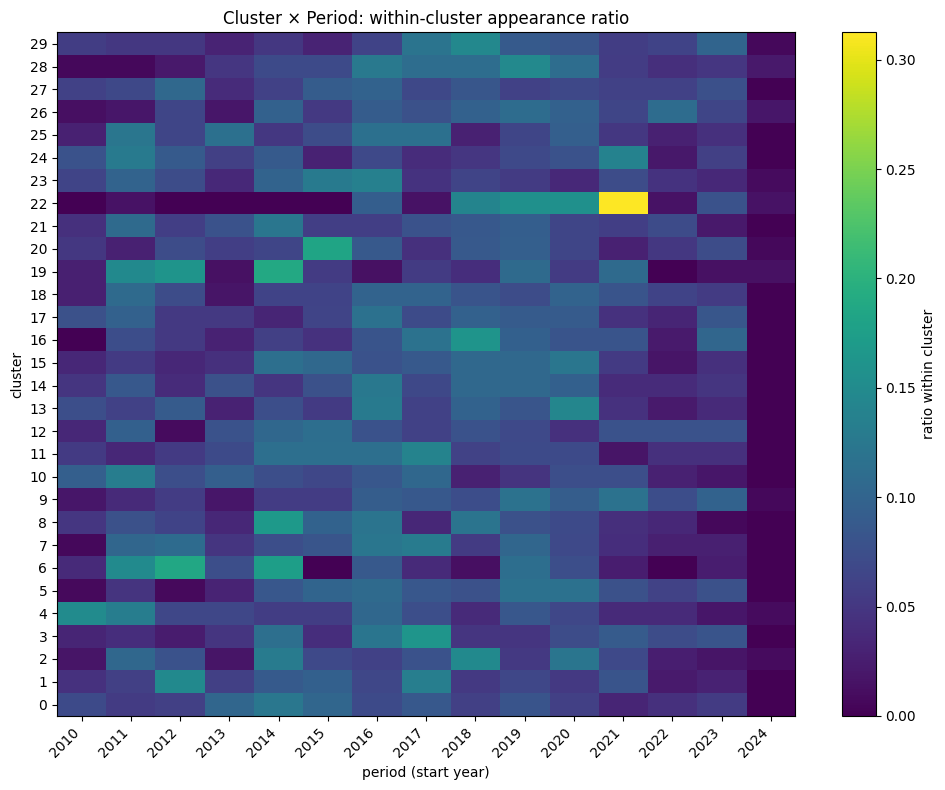

: 

: 

: 

: 

: 

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# periodを昇順に並べ直す（列順）
heat_df = heat_df.reindex(sorted(heat_df.columns), axis=1)

fig, ax = plt.subplots(figsize=(10, 8))

# ヒートマップ本体
im = ax.imshow(
    heat_df.values,
    aspect="auto",
    origin="lower"  # 下からクラスタ 0,1,... を並べる
)

# 軸ラベル
ax.set_xticks(np.arange(len(heat_df.columns)))
ax.set_xticklabels(heat_df.columns, rotation=45, ha="right")
ax.set_xlabel("period (start year)")

ax.set_yticks(np.arange(len(heat_df.index)))
ax.set_yticklabels(heat_df.index)
ax.set_ylabel("cluster")

ax.set_title("Cluster × Period: within-cluster appearance ratio")

# カラーバー（色の意味：そのクラスタ内での period 比率）
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("ratio within cluster")

plt.tight_layout()
plt.show()

In [ ]:
heat_df

: 

: 

: 

: 

: 

: 

In [ ]:
old_period = (2010, 2014)
new_period = (2020, 2024)

df_old = df_out[(df_out["eval_year"] >= old_period[0]) & (df_out["eval_year"] <= old_period[1])]
df_new = df_out[(df_out["eval_year"] >= new_period[0]) & (df_out["eval_year"] <= new_period[1])]

: 

: 

: 

: 

: 

: 

In [ ]:
embeddings = np.load('../embeddings.npy')
X_old = embeddings[df_old.index]
X_new = embeddings[df_new.index]

: 

: 

: 

: 

: 

: 

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

centroid_old = X_old.mean(axis=0, keepdims=True)
centroid_new = X_new.mean(axis=0, keepdims=True)

sim = cosine_similarity(centroid_old, centroid_new)[0][0]
print("Old ↔ New cosine similarity:", sim)

Old ↔ New cosine similarity: 0.99901617


: 

: 

: 

: 

: 

: 

In [ ]:
results = []

for k in sorted(df_out["cluster"].unique()):
    dfk = df_out[df_out["cluster"] == k]

    dfk_old = dfk[(dfk["eval_year"] >= old_period[0]) & (dfk["eval_year"] <= old_period[1])]
    dfk_new = dfk[(dfk["eval_year"] >= new_period[0]) & (dfk["eval_year"] <= new_period[1])]

    if len(dfk_old) < 5 or len(dfk_new) < 5:
        # サンプルが少なすぎると不安定なので除外
        continue

    X_old = embeddings[dfk_old.index]
    X_new = embeddings[dfk_new.index]

    centroid_old = X_old.mean(axis=0, keepdims=True)
    centroid_new = X_new.mean(axis=0, keepdims=True)

    sim = cosine_similarity(centroid_old, centroid_new)[0][0]

    results.append([k, len(dfk_old), len(dfk_new), sim])

df_cluster_sim = pd.DataFrame(results, columns=["cluster", "n_old", "n_new", "similarity"])
df_cluster_sim = df_cluster_sim.sort_values("similarity", ascending=False)

print(df_cluster_sim)

    cluster  n_old  n_new  similarity
0         0     76     35    0.997419
28       29     38     49    0.996879
25       26     33     55    0.996640
17       17     48     39    0.996452
12       12     37     32    0.996067
9         9     30     63    0.995904
7         7     50     24    0.995876
26       27     44     35    0.995739
24       25     53     30    0.995581
8         8     56     22    0.995515
13       13     44     33    0.995398
23       24     45     30    0.995143
22       23     41     22    0.995114
18       18     32     33    0.994881
21       21     57     30    0.994874
16       16     29     39    0.994837
15       15     32     27    0.994699
2         2     40     28    0.994590
20       20     38     31    0.994448
4         4     50     18    0.994068
3         3     32     39    0.993868
11       11     37     20    0.993595
14       14     31     23    0.992924
1         1     54     25    0.992910
10       10     50     21    0.992821
27       28 

: 

: 

: 

: 

: 

: 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# 前提：
# - df_out: 各段落行、列: ["cluster", "eval_year", "text", ...]
# - embeddings: np.ndarray shape (N, D), df_out.index と揃っている

split_year = 2015  # 適宜変えていい

df_out = df_out.copy()
df_out["era"] = np.where(df_out["eval_year"] < split_year, "old", "new")

# コサイン用に正規化しておく
emb = embeddings.astype(float)
emb_norm = emb / np.linalg.norm(emb, axis=1, keepdims=True)

: 

: 

: 

: 

: 

: 

In [ ]:
rows = []

for k, idx_k in df_out.groupby("cluster").groups.items():
    idx_k = np.array(list(idx_k))
    df_k = df_out.loc[idx_k]
    emb_k = emb_norm[idx_k]

    # old / new に分割
    mask_old = (df_k["era"].values == "old")
    mask_new = (df_k["era"].values == "new")
    emb_old = emb_k[mask_old]
    emb_new = emb_k[mask_new]

    n_old, n_new = len(emb_old), len(emb_new)

    if n_old == 0 or n_new == 0:
        rows.append({
            "cluster": k,
            "n_old": n_old,
            "n_new": n_new,
            "sim_centroid": np.nan,
            "avg_nn_dist": np.nan,  # ②で使う
        })
        continue

    # --- (1) 重心コサイン類似度 ---
    c_old = emb_old.mean(axis=0)
    c_old /= np.linalg.norm(c_old)
    c_new = emb_new.mean(axis=0)
    c_new /= np.linalg.norm(c_new)
    sim_centroid = float(np.dot(c_old, c_new))

    # (2) 用の器だけ用意しておく（あとで埋める）
    rows.append({
        "cluster": k,
        "n_old": n_old,
        "n_new": n_new,
        "sim_centroid": sim_centroid,
        "avg_nn_dist": None,  # 後で更新
    })

drift_df = pd.DataFrame(rows).set_index("cluster")

: 

: 

: 

: 

: 

: 

In [ ]:
rows = []

for k, idx_k in df_out.groupby("cluster").groups.items():
    idx_k = np.array(list(idx_k))
    df_k = df_out.loc[idx_k]
    emb_k = emb_norm[idx_k]

    mask_old = (df_k["era"].values == "old")
    mask_new = (df_k["era"].values == "new")
    emb_old = emb_k[mask_old]
    emb_new = emb_k[mask_new]

    n_old, n_new = len(emb_old), len(emb_new)

    if n_old == 0 or n_new == 0:
        sim_centroid = np.nan
        avg_nn_dist = np.nan
    else:
        # 重心類似度
        c_old = emb_old.mean(axis=0)
        c_old /= np.linalg.norm(c_old)
        c_new = emb_new.mean(axis=0)
        c_new /= np.linalg.norm(c_new)
        sim_centroid = float(np.dot(c_old, c_new))

        # new → old の最近傍コサイン類似度
        sim_matrix = cosine_similarity(emb_new, emb_old)  # shape (n_new, n_old)
        max_sim_new2old = sim_matrix.max(axis=1)          # 各 new の最も近い old との類似度
        avg_nn_dist = float(np.mean(1.0 - max_sim_new2old))

    rows.append({
        "cluster": k,
        "n_old": n_old,
        "n_new": n_new,
        "sim_centroid": sim_centroid,
        "avg_nn_dist": avg_nn_dist,
    })

drift_df = (
    pd.DataFrame(rows)
    .sort_values("sim_centroid")  # or "avg_nn_dist" でソート
)

print(drift_df)

    cluster  n_old  n_new  sim_centroid  avg_nn_dist
22       22      1     63      0.932003     0.110970
6         6     50     30      0.993195     0.078487
5         5     23    106      0.993800     0.123274
28       28     22    121      0.994792     0.105589
19       19     40     34      0.994907     0.088170
14       14     31     73      0.994930     0.087960
3         3     32     91      0.995597     0.084227
16       16     29    107      0.995740     0.078505
20       20     38     99      0.996004     0.087677
2         2     40     75      0.996061     0.082556
11       11     37     77      0.996195     0.085313
18       18     32     79      0.996447     0.098710
4         4     50     56      0.996467     0.092965
10       10     50     56      0.996576     0.084275
24       24     45     56      0.996580     0.103614
21       21     57     82      0.996637     0.076819
27       27     44     88      0.996692     0.092354
25       25     53     85      0.996718     0.

: 

: 

: 

: 

: 

: 

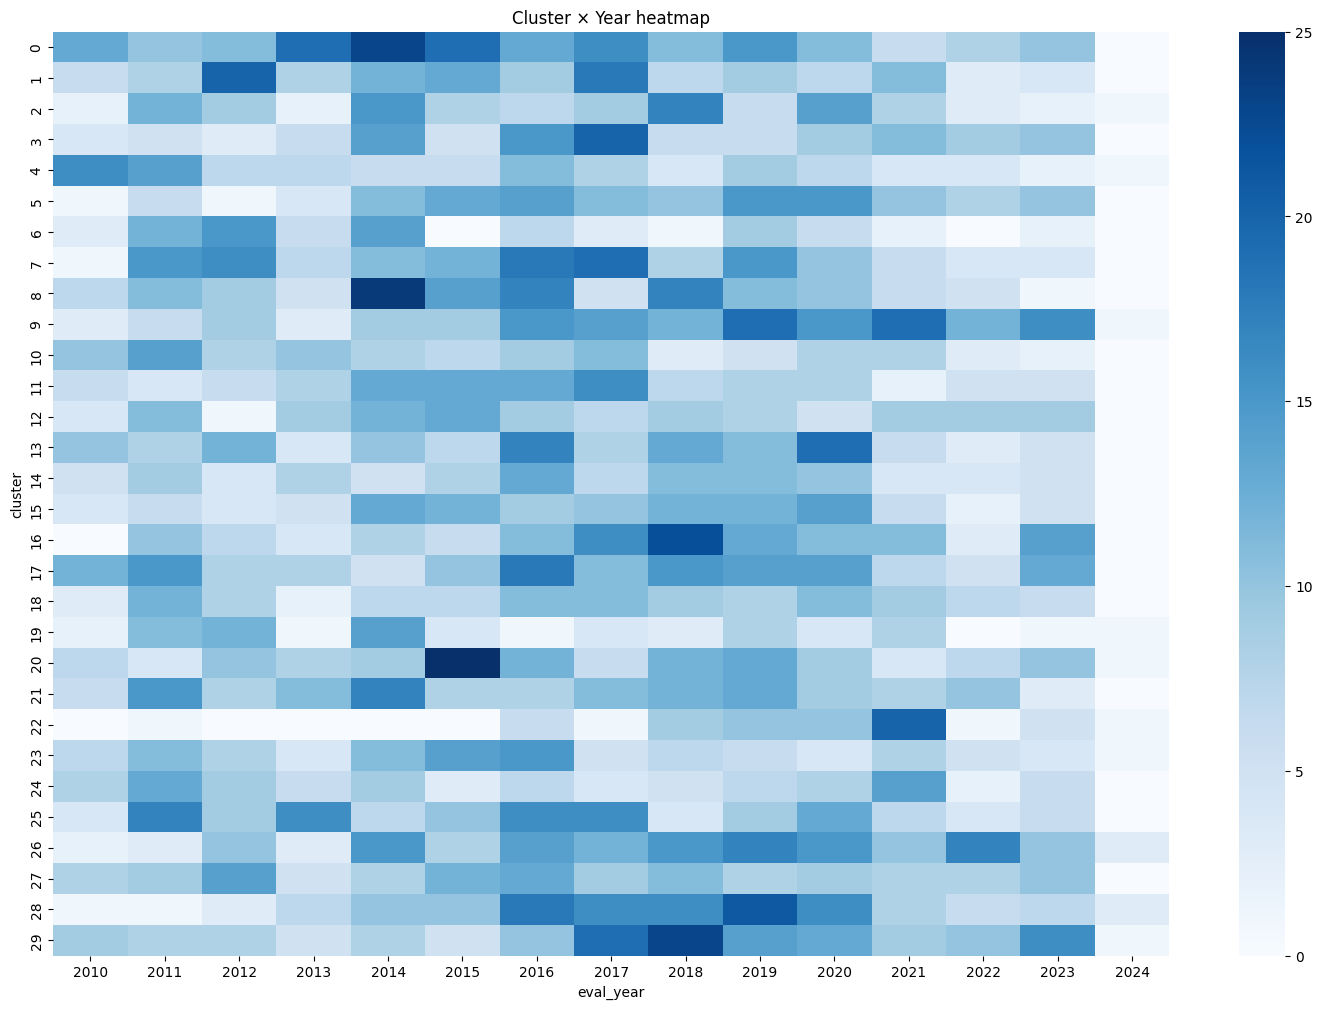

: 

: 

: 

: 

: 

: 

In [ ]:
# df_out を使う
df_year_cluster = (
    df_out
    .groupby(["eval_year", "cluster"])
    .size()
    .reset_index(name="count")
)

pivot = df_year_cluster.pivot(index="cluster", columns="eval_year", values="count").fillna(0)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18,12))
sns.heatmap(pivot, cmap="Blues", norm=None)   # 必要ならログスケールにする
plt.title("Cluster × Year heatmap")
plt.show()

In [ ]:
# クラスタごとの重心（全部の era をまとめた重心）
cluster_centers = {}

for k, idx_k in df_out.groupby("cluster").groups.items():
    idx_k = np.array(list(idx_k))
    emb_k = emb_norm[idx_k]
    c = emb_k.mean(axis=0)
    c /= np.linalg.norm(c)
    cluster_centers[k] = c

# 各段落について「クラスタ重心とのコサイン類似度」を計算
sim_to_center = []

for i, row in df_out.iterrows():
    k = row["cluster"]
    c = cluster_centers[k]
    v = emb_norm[i]
    sim_to_center.append(float(np.dot(v, c)))

df_out["sim_to_center"] = sim_to_center


: 

: 

: 

: 

: 

: 

In [ ]:

N = 5
cluster_id = 19

rep_samples = (
    df_out[df_out["cluster"] == cluster_id]
    .sort_values("sim_to_center", ascending=False)
    .groupby("era")
    .head(N)
    .sort_values(["era", "sim_to_center"], ascending=[True, False])
    [["era", "eval_year", "sim_to_center", "text"]]
)

rep_samples['text']

1701    】・ 既述のとおり、修理・部品交換を行うことができる技術者が現地にいなかったり、消耗品・部品...
3291    したがって、今後類似の事業を展開する際には、責任ある漁業のトレーサビリティと効果的な漁業管理...
3748    事業完了7 年後、沿岸部に設置された通信機器が空気中の多量の塩分により劣化していることが判...
3017    漁港施設案件において施設や機材が有効に活用されるためには、ハード面で適切な施設や機材が調達さ...
3309    すべての関係機関との十分な協議を通じた合意形成の重要性本事業では、泊地の水深に関する関係機関...
1051    本事業では発電機も供与されたが、その運用に費用がかかることから、緊急時以外は利用されていない...
1014    事業計画段階において、被援助国及び日本の政策や開発ニーズへの高い妥当性が確認されたとしても...
343     z本事業は、オウイアに水揚していなかった地曳網漁船の漁獲物をセンターで水揚させる、漁民が独自...
1050    さらにいえば、事業計画時に実施機関の行政機能が政治不安によって適切に働いていないとJICA ...
345     1)本事業のメインアウトプットは桟橋施設の整備であったが、プロジェクト全体の効果発現にあたっ...
Name: text, dtype: object

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 